# Time Series Forecasting


- In this project, I am going to investigate the seasonality, decompose the series based on our seasonality and trend findings and lastly prepare ARIMA models comparing the performance of each other. The data is provided by  https://seffaflik.epias.com.tr/transparency/ and the scope of the data is from 1st of January, 2016 till the 20th of May, 2021.


# Task 1 

## 1 ) Importing and Manipulating the Data
- At first, I added the hour column to the index in order to plot it properly but I did not want to lose the hour information so I kept the date and hour column seperately beside from index. Then I added day, month and week information from my datetime which I converted from the original index to plot the consumption data according to those information. 

In [131]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [132]:
df = pd.read_csv("Consumption.csv")
cons = df.copy()
cons.head()

,Date,Hour,Consumption (MWh)
0,01/01/2016,00:00,26277.24
1,01/01/2016,01:00,24991.82
2,01/01/2016,02:00,23532.61
3,01/01/2016,03:00,22464.78
4,01/01/2016,04:00,22002.91


In [133]:
index = cons["Date"]+ " " +cons["Hour"]
hourly_date = pd.to_datetime(index, format = "%d/%m/%Y %H:%M")
cons.rename(columns={"Consumption (MWh)": "Consumption"}, inplace = True)
cons.set_index(hourly_date, inplace = True)
cons["Date"] = pd.to_datetime(cons["Date"], format = "%d/%m/%Y")
cons['Day'] = cons['Date'].dt.day_name()
cons['Month'] = cons['Date'].dt.month_name()
cons['Week'] = cons.Date.apply(lambda x : x.weekofyear)

In [134]:
cons.head()

,Date,Hour,Consumption,Day,Month,Week
2016-01-01 00:00:00,2016-01-01,00:00,26277.24,Friday,January,53
2016-01-01 01:00:00,2016-01-01,01:00,24991.82,Friday,January,53
2016-01-01 02:00:00,2016-01-01,02:00,23532.61,Friday,January,53
2016-01-01 03:00:00,2016-01-01,03:00,22464.78,Friday,January,53
2016-01-01 04:00:00,2016-01-01,04:00,22002.91,Friday,January,53


In [135]:
cons.describe().T # overall statistics 

,count,mean,std,min,25%,50%,75%,max
Consumption,47208.0,33010.591211,5101.679826,0.0,29056.5925,33105.98,36683.55,49341.89
Week,47208.0,25.505846,15.215973,1.0,12.0000,25.00,39.00,53.00


In [136]:
cons.isnull().values.any() # checked whether there is null values or not  

False

## 2 ) Seasonality and Trend Analysis

### Hourly Base

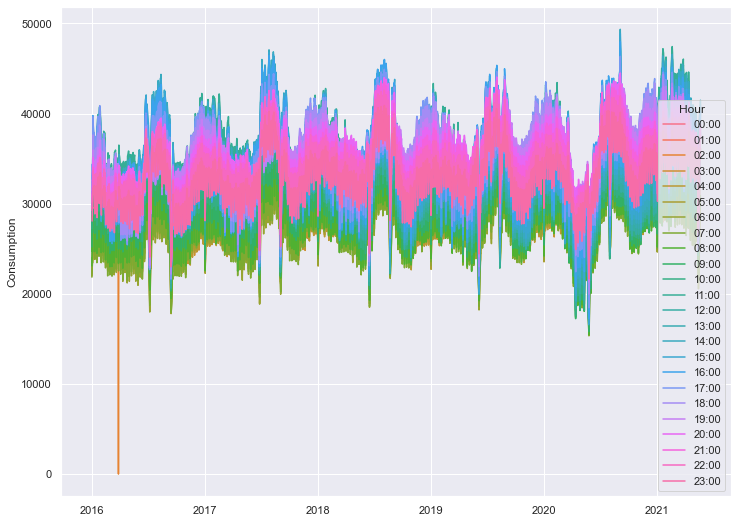

In [137]:
sns.set(rc={'figure.figsize':(12,9)})

sns.lineplot(x = cons.index, y = "Consumption", hue = "Hour", data = cons);

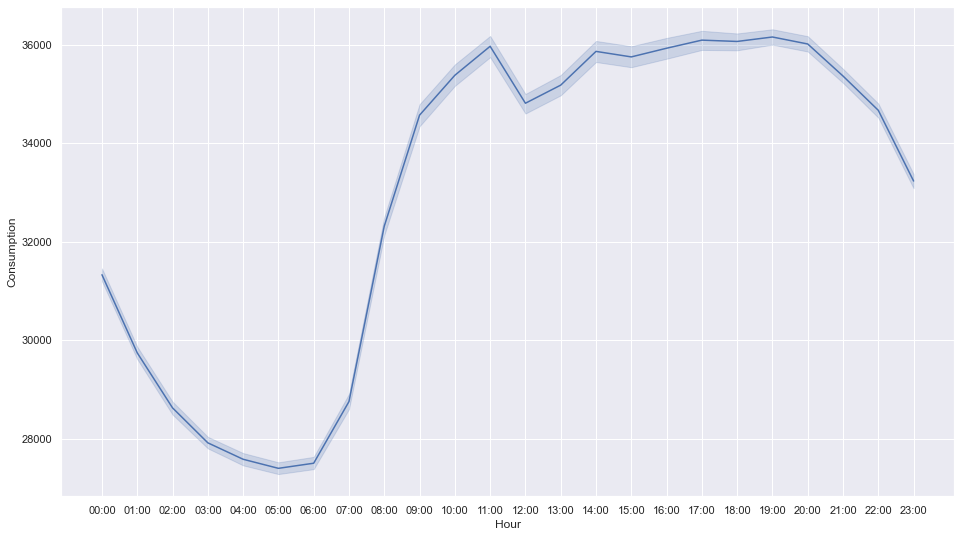

In [138]:
sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(x = cons.Hour, y = "Consumption", data = cons);

- When I plot the consumption data on hourly basis, we see that there is seasonal effect on the data on the hourly basis such that in similar hours, consumption data is also similar. This could derive from that people and also the industry tend to use less electricity between 24:00 and working hours.  

### Weekly Base

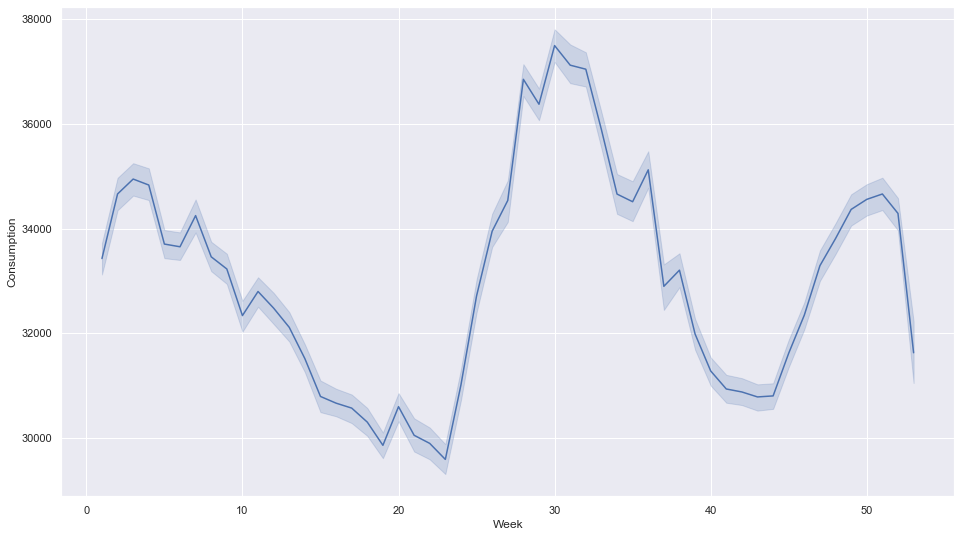

In [139]:
sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(x = cons.Week, y = "Consumption", data = cons);

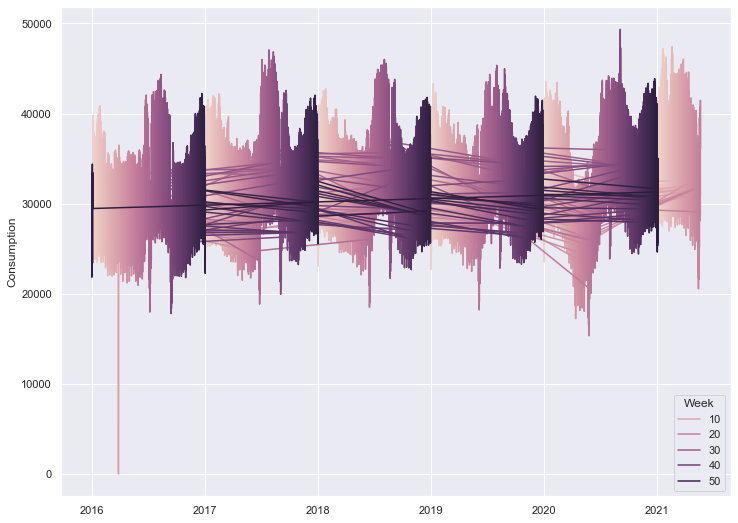

In [140]:
sns.set(rc={'figure.figsize':(12,9)})
sns.lineplot(x = cons.index, y = "Consumption", hue = "Week", data = cons);

### Monthly Base

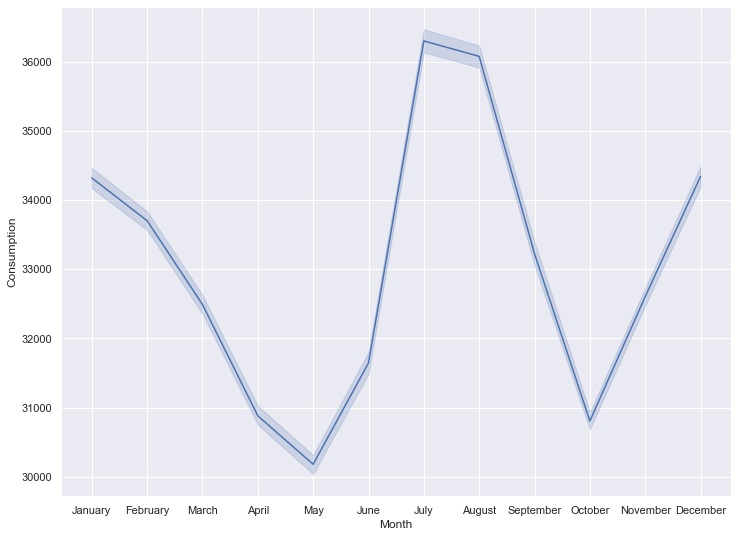

In [141]:
sns.set(rc={'figure.figsize':(12,9)})
sns.lineplot(x = cons.Month, y = "Consumption", data = cons);

- When I plot the consumption data on weekly and monthly basis, we also see that there is seasonal effect on the data. This might be caused from that production behaviour of the industry is not same throughout the year.   

## 3 ) Decomposing the Data on weekly,daily and hourly basis 

### Weekly Decompositon

### I dropped the columns except the week information to decompose on the weekly basis 

In [142]:
weekly = cons.copy()
weekly.drop("Hour" , axis = 'columns' , inplace = True)
weekly.drop("Day" , axis = 'columns' , inplace = True)
weekly.drop("Month" , axis = 'columns' , inplace = True)
weekly.drop("Date" , axis = 'columns' , inplace = True)
weekly.drop("Week" , axis = 'columns' , inplace = True)
weekly

,Consumption
2016-01-01 00:00:00,26277.24
2016-01-01 01:00:00,24991.82
2016-01-01 02:00:00,23532.61
2016-01-01 03:00:00,22464.78
2016-01-01 04:00:00,22002.91
...,...
2021-05-20 19:00:00,37793.51
2021-05-20 20:00:00,38805.79
2021-05-20 21:00:00,38413.45
2021-05-20 22:00:00,37630.77


In [143]:
weekly = weekly[(weekly.T != 0).any()] # the decomposing function does not work with zero values so I delete one value
weekly

,Consumption
2016-01-01 00:00:00,26277.24
2016-01-01 01:00:00,24991.82
2016-01-01 02:00:00,23532.61
2016-01-01 03:00:00,22464.78
2016-01-01 04:00:00,22002.91
...,...
2021-05-20 19:00:00,37793.51
2021-05-20 20:00:00,38805.79
2021-05-20 21:00:00,38413.45
2021-05-20 22:00:00,37630.77


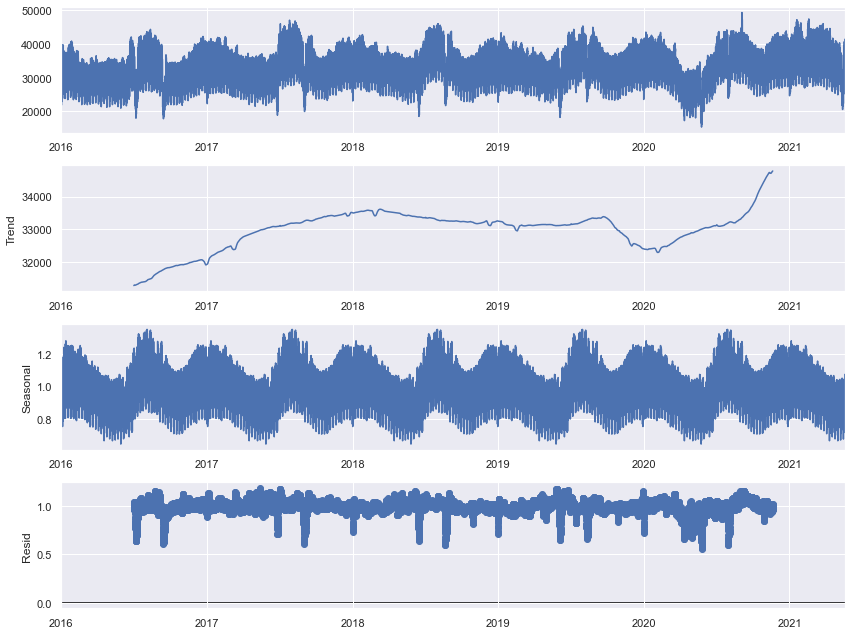

In [144]:

result = seasonal_decompose(weekly, model='multiplicative', period = 24*7*52) # Since the data is hourly one week is equal to 24*7*52
result.plot()
plt.show();

- We see that on the weekly basis there is a seasonality such that after decomposing the series, residuals are more like WN series. But there is still a seasonality effect on the residuals so we should investigate more. There is also a slight increasing trend. 

### Monthly Decomposition

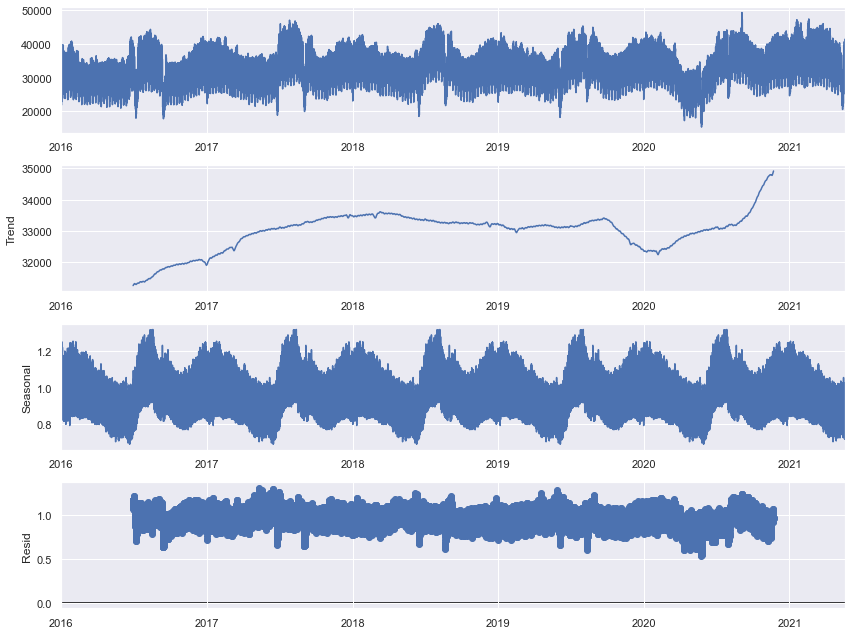

In [145]:

result = seasonal_decompose(weekly, model='multiplicative', period = 24*30*12) # Since the data is hourly one month is equal to 24*30*12
result.plot()
plt.show();

- We see that on the monthly basis there is also a seasonality such that after decomposing the series, residuals are more like WN series. But there is still a seasonality effect on the residuals so we should investigate more. Also, there is a slight increasing trend also in this base. 


### Daily Decompositon

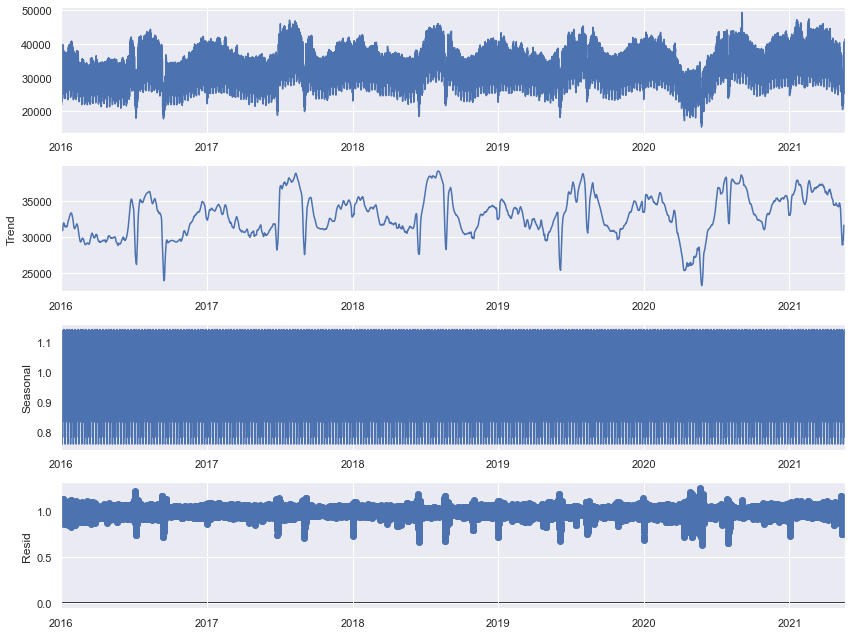

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(weekly, model='multiplicative', period = 24*7) # Since the data is hourly one month is equal to 24*7
result.plot()
plt.show();

### Hourly Decompositon

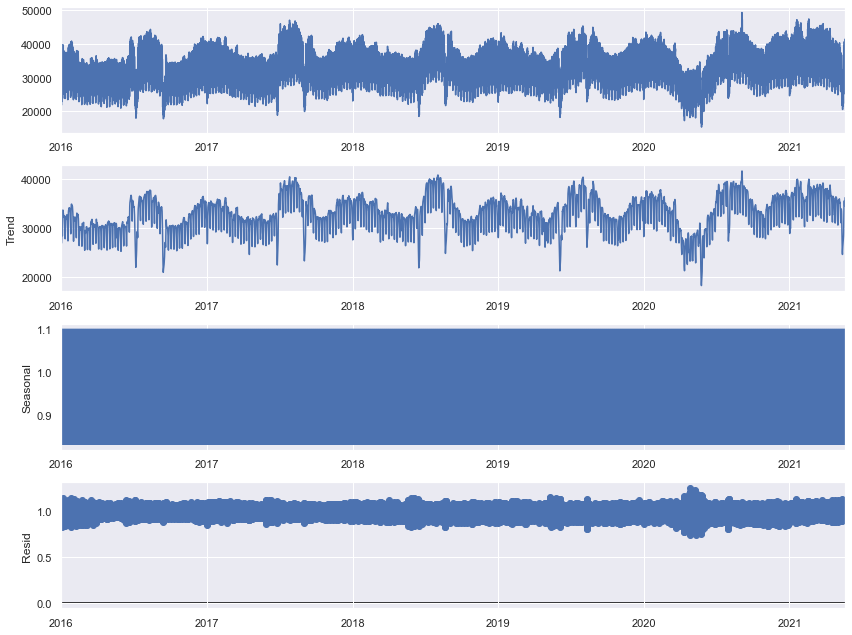

In [147]:

result = seasonal_decompose(weekly, model='multiplicative', period = 24) 
result.plot()
plt.show();

- Since the data points on hourly level is so much, it is hard to understand seasonal effect on hourly basis from the graph above so I decided to use ACF function of detrended values

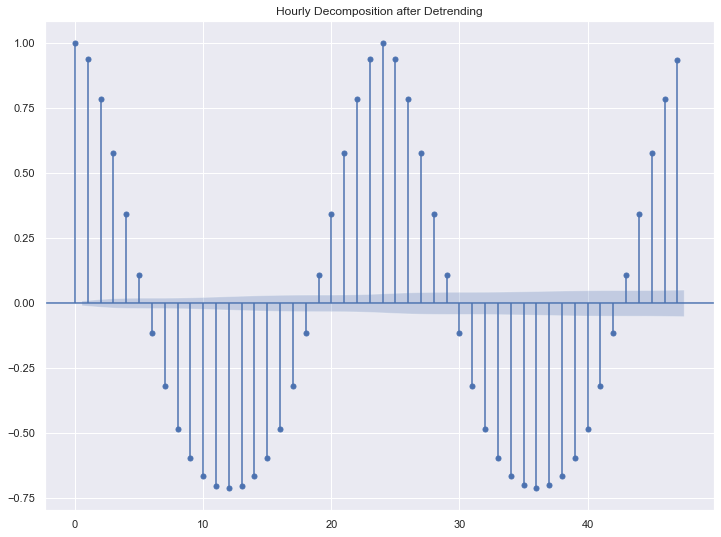

In [148]:

plot_acf(result.seasonal)
plt.title("Hourly Decomposition after Detrending")
plt.show();

- Looking the decompositons on different levels, wee see that on hourly and daily basis there is a significant seasonality  behaviour because the residulas are more like WN. We can also see the hourly seasonality from the ACF function above. So we can continue our model with daily and hourly seasonality. There is no significant trend in this base. 

 # Task 2 

-  In this part, we are going to decompose our  consumption series according to our findings above and the information given  which is there is a pattern every 168 hours.

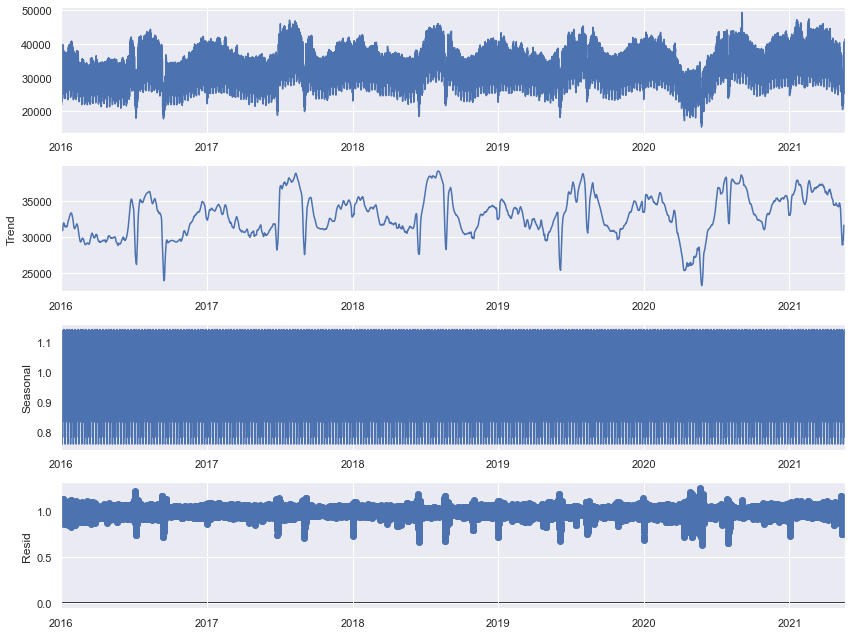

In [149]:

result = seasonal_decompose(weekly, model='multiplicative', period = 24*7) # Since the data is hourly one month is equal to 24*7*30
result.plot()
plt.show();

-After decomposing the series with the period 24*7, wee see that the residauls are more like WN series except from the some peaks which may be caused from special holiday days. We can prepare our model now after detrending and deseasonaling. 

# Task 3 

-In this part, we are going to detrend and deseasonalise our data with our finding in task 2. After, we are going to decide the parameter p looking at lag values to prepare a AR model. 

In [150]:
trend = result.trend
trend[100:110]

2016-01-05 04:00:00    31468.499732
2016-01-05 05:00:00    31504.280774
2016-01-05 06:00:00    31534.692262
2016-01-05 07:00:00    31559.914196
2016-01-05 08:00:00    31582.900804
2016-01-05 09:00:00    31604.713065
2016-01-05 10:00:00    31627.227173
2016-01-05 11:00:00    31650.827887
2016-01-05 12:00:00    31673.550625
2016-01-05 13:00:00    31694.490298
Name: trend, dtype: float64

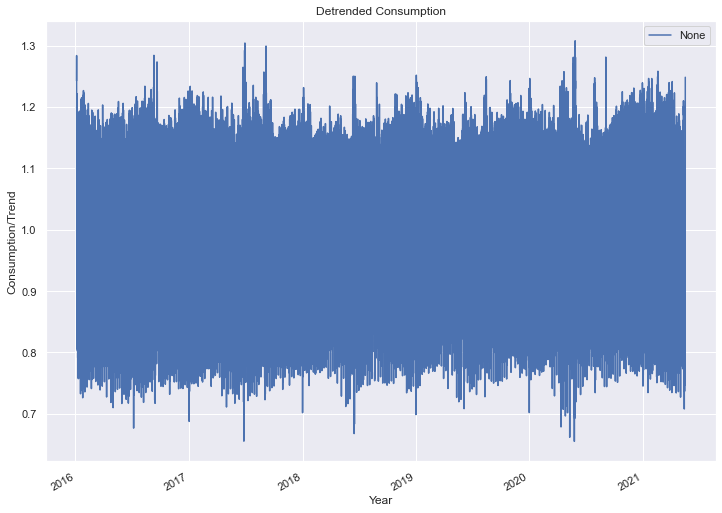

In [151]:
detrended = weekly["Consumption"]/trend
detrended.plot();
plt.title(label='Detrended Consumption')
plt.xlabel("Year")
plt.ylabel("Consumption/Trend")
plt.legend()
plt.show()

In [152]:
seasonality = result.seasonal
seasonality[100:110]

2016-01-05 04:00:00    0.846445
2016-01-05 05:00:00    0.853765
2016-01-05 06:00:00    0.899735
2016-01-05 07:00:00    1.020634
2016-01-05 08:00:00    1.093262
2016-01-05 09:00:00    1.114554
2016-01-05 10:00:00    1.129909
2016-01-05 11:00:00    1.090520
2016-01-05 12:00:00    1.105200
2016-01-05 13:00:00    1.127898
Name: seasonal, dtype: float64

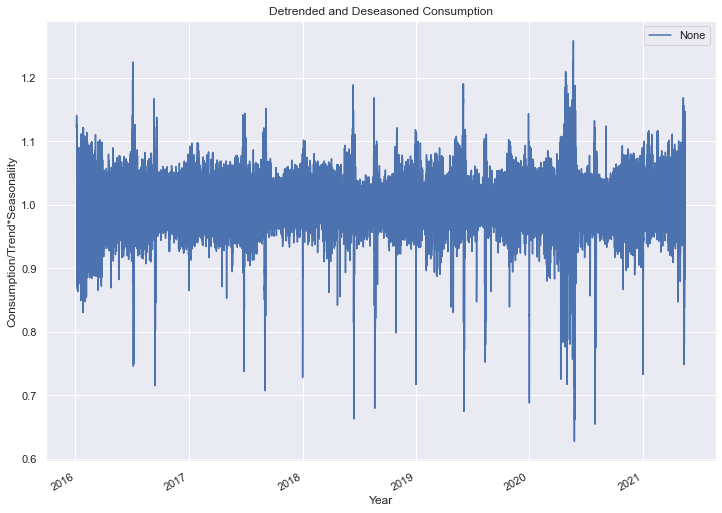

In [153]:
deseasoned = detrended/seasonality
deseasoned.plot();
plt.title(label='Detrended and Deseasoned Consumption')
plt.xlabel("Year")
plt.ylabel("Consumption/Trend*Seasonality")
plt.legend()
plt.show()

- The KPSS unit root test says that our data is not stationary but the homework task 3 says that we should continue with the 7*24 hours, I'm going to continue with that. However, I would prefer hourly seasonality if I were to choose one. Now our data is detrended and deseasonalized, we can look for appropriate p value for the AR model checking ACF and PACF function. 

In [157]:
model_data = result.resid.dropna()
model_data

2016-01-04 12:00:00    1.127120
2016-01-04 13:00:00    1.128456
2016-01-04 14:00:00    1.140877
2016-01-04 15:00:00    1.120874
2016-01-04 16:00:00    1.135093
                         ...   
2021-05-17 07:00:00    1.035219
2021-05-17 08:00:00    1.071929
2021-05-17 09:00:00    1.077853
2021-05-17 10:00:00    1.098091
2021-05-17 11:00:00    1.110845
Name: resid, Length: 47039, dtype: float64

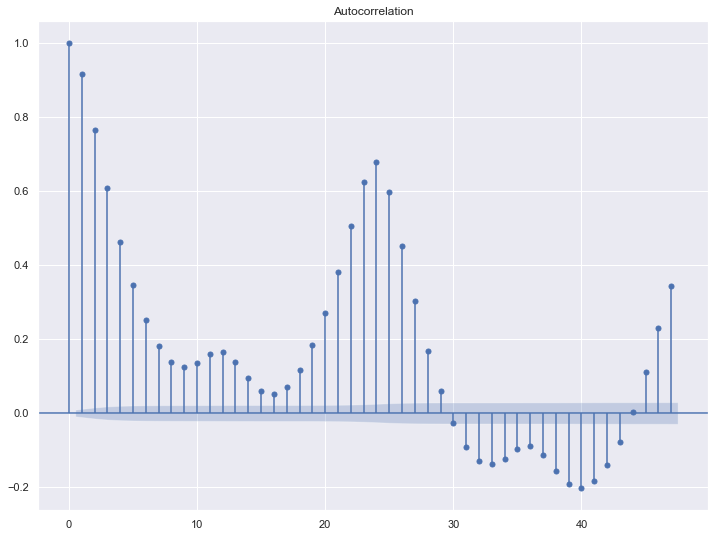

In [155]:
plot_acf(model_data)
plt.show()

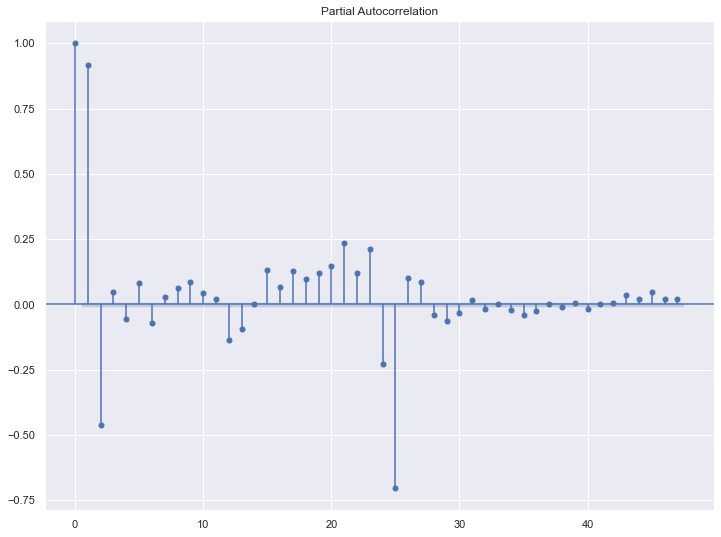

In [156]:

plot_pacf(model_data)
plt.show()

- Exponential decaying in ACF function and dramatic drop in PACF function suggests that AR model can be used. For a proper p value, I'm going to check AIC values as p changes. For initial value of p, I am going to use p is equal to 3. 

## AR Model

In [158]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(model_data, order=(3,0,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(3, 0, 0)   Log Likelihood              128527.528
Date:                Sun, 06 Jun 2021   AIC                        -257045.055
Time:                        20:11:09   BIC                        -257001.262
Sample:                             0   HQIC                       -257031.298
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.001   1593.121      0.000       0.998       1.001
ar.L1          1.3595      0.003    441.026      0.000       1.353       1.366
ar.L2         -0.5231      0.006    -92.651      0.000      -0.534      -0.512
ar.L3          0.0467      0.004     12.541      0.000       0.039       0.054
sigma2         0.0002   9.73e-07    254.736      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):             32747.60
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(model_data, order=(4,0,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(4, 0, 0)   Log Likelihood              128606.709
Date:                Sun, 06 Jun 2021   AIC                        -257201.417
Time:                        20:11:42   BIC                        -257148.865
Sample:                             0   HQIC                       -257184.909
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.001   1661.270      0.000       0.998       1.001
ar.L1          1.3623      0.003    443.943      0.000       1.356       1.368
ar.L2         -0.5534      0.006    -93.078      0.000      -0.565      -0.542
ar.L3          0.1256      0.006     19.340      0.000       0.113       0.138
ar.L4         -0.0580      0.004    -15.619      0.000      -0.065      -0.051
sigma2         0.0002   9.67e-07    255.281      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):             34267.00
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The AIC decreased so the model has improved as we increased the p value. Thus, 4,0,0 is a better model

In [160]:
model = ARIMA(model_data, order=(5,0,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(5, 0, 0)   Log Likelihood              128769.390
Date:                Sun, 06 Jun 2021   AIC                        -257524.780
Time:                        20:12:26   BIC                        -257463.468
Sample:                             0   HQIC                       -257505.520
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.001   1531.976      0.000       0.998       1.001
ar.L1          1.3671      0.003    448.423      0.000       1.361       1.373
ar.L2         -0.5640      0.006    -94.451      0.000      -0.576      -0.552
ar.L3          0.1716      0.007     23.903      0.000       0.158       0.186
ar.L4         -0.1711      0.007    -24.696      0.000      -0.185      -0.158
ar.L5          0.0830      0.004     21.314      0.000       0.075       0.091
sigma2         0.0002   9.82e-07    249.704      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):             31852.57
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The AIC decreased so the model has improved as we increased the p value. Thus, 5,0,0 is a better model

In [161]:
model = ARIMA(model_data, order=(6,0,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(6, 0, 0)   Log Likelihood              128885.457
Date:                Sun, 06 Jun 2021   AIC                        -257754.914
Time:                        20:12:54   BIC                        -257684.844
Sample:                             0   HQIC                       -257732.903
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.001   1629.150      0.000       0.998       1.001
ar.L1          1.3729      0.003    434.637      0.000       1.367       1.379
ar.L2         -0.5759      0.006    -90.216      0.000      -0.588      -0.563
ar.L3          0.1836      0.008     24.053      0.000       0.169       0.199
ar.L4         -0.2107      0.007    -28.746      0.000      -0.225      -0.196
ar.L5          0.1789      0.006     29.427      0.000       0.167       0.191
ar.L6         -0.0702      0.004    -17.334      0.000      -0.078      -0.062
sigma2         0.0002   9.92e-07    246.004      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):             29411.72
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Comments 

-The AIC decreased so the model has improved as we increased the p value. Thus, 6,0,0 is a better model. But there is no need to increase p value further because the AIC value is not decreasing significantly. Also it may cause overfitting.

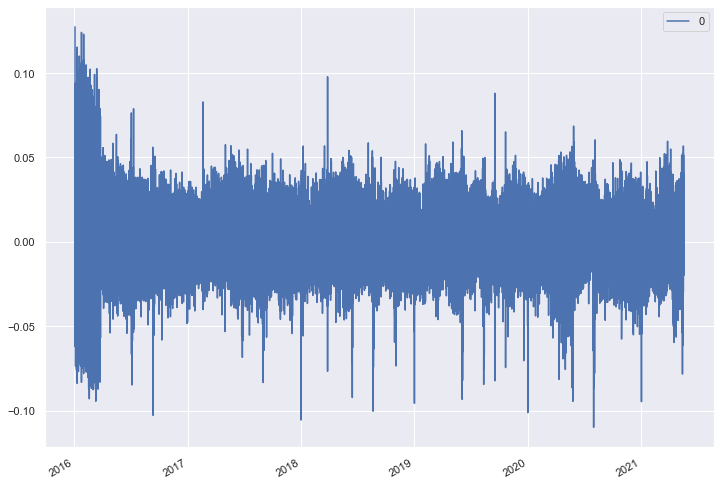

In [162]:

residuals = pd.DataFrame(model_fit.resid)
residuals.plot();

# Task 4 

## MA Model 

- We can start with q = 1 because there is a dramatic decrease in PACF function starting from lag 1. 

In [163]:
model = ARIMA(model_data, order=(0,0,1))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(0, 0, 1)   Log Likelihood              105272.555
Date:                Sun, 06 Jun 2021   AIC                        -210539.110
Time:                        20:14:03   BIC                        -210512.834
Sample:                             0   HQIC                       -210530.856
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.000   4226.939      0.000       0.999       1.000
ma.L1          0.8848      0.002    458.318      0.000       0.881       0.889
sigma2         0.0007   2.59e-06    257.298      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):               20281.06   Jarque-Bera (JB):             52369.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- AIC value is higher than AR model. We can check for other q values to find best model with MA 

In [164]:
model = ARIMA(model_data, order=(0,0,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(0, 0, 2)   Log Likelihood              116610.347
Date:                Sun, 06 Jun 2021   AIC                        -233212.693
Time:                        20:14:31   BIC                        -233177.658
Sample:                             0   HQIC                       -233201.687
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.000   3640.850      0.000       0.999       1.000
ma.L1          1.2530      0.002    528.488      0.000       1.248       1.258
ma.L2          0.5889      0.002    255.765      0.000       0.584       0.593
sigma2         0.0004   1.61e-06    254.831      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                4512.23   Jarque-Bera (JB):             31687.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The AIC value decreased so our model got better, we check for other q values. 

In [165]:
model = ARIMA(model_data, order=(0,0,3))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(0, 0, 3)   Log Likelihood              123489.356
Date:                Sun, 06 Jun 2021   AIC                        -246968.712
Time:                        20:15:20   BIC                        -246924.918
Sample:                             0   HQIC                       -246954.955
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.000   3124.945      0.000       0.999       1.000
ma.L1          1.3122      0.003    450.478      0.000       1.306       1.318
ma.L2          1.0081      0.004    256.348      0.000       1.000       1.016
ma.L3          0.5119      0.003    166.796      0.000       0.506       0.518
sigma2         0.0003   1.25e-06    244.951      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                1578.84   Jarque-Bera (JB):             21740.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The AIC value decreased so our model got better, we check for other q values. 

In [166]:
model = ARIMA(model_data, order=(0,0,4))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(0, 0, 4)   Log Likelihood              126192.869
Date:                Sun, 06 Jun 2021   AIC                        -252373.737
Time:                        20:16:21   BIC                        -252321.185
Sample:                             0   HQIC                       -252357.228
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.000   2734.643      0.000       0.999       1.000
ma.L1          1.3711      0.003    432.657      0.000       1.365       1.377
ma.L2          1.1761      0.005    245.754      0.000       1.167       1.185
ma.L3          0.8166      0.005    165.090      0.000       0.807       0.826
ma.L4          0.3101      0.003     92.480      0.000       0.303       0.317
sigma2         0.0003   1.16e-06    235.403      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 279.08   Jarque-Bera (JB):             18839.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [167]:
model = ARIMA(model_data, order=(0,0,5))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                47039
Model:                 ARIMA(0, 0, 5)   Log Likelihood              127675.840
Date:                Sun, 06 Jun 2021   AIC                        -255337.679
Time:                        20:17:46   BIC                        -255276.368
Sample:                             0   HQIC                       -255318.419
                              - 47039                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.000   2362.390      0.000       0.999       1.000
ma.L1          1.3826      0.003    426.821      0.000       1.376       1.389
ma.L2          1.2715      0.005    251.270      0.000       1.262       1.281
ma.L3          1.0452      0.006    186.738      0.000       1.034       1.056
ma.L4          0.6094      0.005    115.630      0.000       0.599       0.620
ma.L5          0.2294      0.004     62.364      0.000       0.222       0.237
sigma2         0.0003   1.04e-06    246.619      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  45.45   Jarque-Bera (JB):             25656.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AIC values decreased but the decrease is smaller than the other trials also the model fitting time increased. Therefore, we can stop trying further q values and decide q = 5. Final model for MA is (0,0,5)

# Task 5 

### In this part, we asked to compare the results on task 3 and task 4 and then build a ARIMA model according to our findings. First AIC value of AR model with order (6,0,0) is better than the MA model with order (0,0,5) bu their values are close to each other. I think it is reasonable to use both AR and MA models so ARIMA model to fit predict better values. Im going to start with p = 3 and q = 1 as in the task 3 and task 4. 

## Splitting Test and Train Data 

In [168]:
train_data = model_data.drop(model_data.tail(14*24-84).index)
train_data

2016-01-04 12:00:00    1.127120
2016-01-04 13:00:00    1.128456
2016-01-04 14:00:00    1.140877
2016-01-04 15:00:00    1.120874
2016-01-04 16:00:00    1.135093
                         ...   
2021-05-06 19:00:00    0.950650
2021-05-06 20:00:00    0.943420
2021-05-06 21:00:00    0.979198
2021-05-06 22:00:00    0.987484
2021-05-06 23:00:00    0.998651
Name: resid, Length: 46787, dtype: float64

In [184]:
test_data = cons["Consumption"].tail(14*24)
test_data

2021-05-07 00:00:00    34407.89
2021-05-07 01:00:00    32984.77
2021-05-07 02:00:00    32736.92
2021-05-07 03:00:00    31913.44
2021-05-07 04:00:00    31318.70
                         ...   
2021-05-20 19:00:00    37793.51
2021-05-20 20:00:00    38805.79
2021-05-20 21:00:00    38413.45
2021-05-20 22:00:00    37630.77
2021-05-20 23:00:00    36126.55
Name: Consumption, Length: 336, dtype: float64

In [170]:
model = ARIMA(train_data, order=(3,0,1))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(3, 0, 1)   Log Likelihood              128276.445
Date:                Sun, 06 Jun 2021   AIC                        -256540.891
Time:                        20:19:53   BIC                        -256488.370
Sample:                             0   HQIC                       -256524.388
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.001   1657.945      0.000       0.998       1.001
ar.L1          0.5368      0.010     51.884      0.000       0.517       0.557
ar.L2          0.5599      0.015     36.433      0.000       0.530       0.590
ar.L3         -0.3192      0.007    -43.734      0.000      -0.333      -0.305
ma.L1          0.8451      0.009     90.010      0.000       0.827       0.863
sigma2         0.0002   9.57e-07    253.477      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.70   Jarque-Bera (JB):             32787.09
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [171]:
model = ARIMA(train_data, order=(4,0,1))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(4, 0, 1)   Log Likelihood              128224.776
Date:                Sun, 06 Jun 2021   AIC                        -256435.553
Time:                        20:20:28   BIC                        -256374.279
Sample:                             0   HQIC                       -256416.300
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9992      0.001   1675.633      0.000       0.998       1.000
ar.L1          0.8168      0.021     39.524      0.000       0.776       0.857
ar.L2          0.1733      0.029      6.010      0.000       0.117       0.230
ar.L3         -0.1135      0.014     -8.210      0.000      -0.141      -0.086
ar.L4         -0.0703      0.005    -15.292      0.000      -0.079      -0.061
ma.L1          0.5541      0.021     26.188      0.000       0.513       0.596
sigma2         0.0002   9.86e-07    248.113      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             33125.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [172]:
model = ARIMA(train_data, order=(4,0,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as start

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(4, 0, 2)   Log Likelihood              128250.891
Date:                Sun, 06 Jun 2021   AIC                        -256485.782
Time:                        20:21:55   BIC                        -256415.755
Sample:                             0   HQIC                       -256463.779
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0003      0.001   1654.900      0.000       0.999       1.001
ar.L1          0.3174      0.047      6.742      0.000       0.225       0.410
ar.L2          0.4382      0.032     13.621      0.000       0.375       0.501
ar.L3          0.1844      0.028      6.700      0.000       0.130       0.238
ar.L4         -0.2395      0.014    -16.850      0.000      -0.267      -0.212
ma.L1          1.0547      0.048     22.075      0.000       0.961       1.148
ma.L2          0.4341      0.038     11.330      0.000       0.359       0.509
sigma2         0.0002   9.61e-07    250.860      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             32122.90
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
model = ARIMA(train_data, order=(5,0,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as start

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(5, 0, 2)   Log Likelihood              128288.219
Date:                Sun, 06 Jun 2021   AIC                        -256558.439
Time:                        20:23:34   BIC                        -256479.659
Sample:                             0   HQIC                       -256533.685
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9997      0.001   1614.134      0.000       0.998       1.001
ar.L1          0.3991      0.056      7.176      0.000       0.290       0.508
ar.L2          0.2909      0.043      6.721      0.000       0.206       0.376
ar.L3          0.2609      0.026     10.037      0.000       0.210       0.312
ar.L4         -0.2898      0.013    -22.902      0.000      -0.315      -0.265
ar.L5          0.0469      0.006      8.280      0.000       0.036       0.058
ma.L1          0.9692      0.056     17.451      0.000       0.860       1.078
ma.L2          0.4635      0.038     12.112      0.000       0.388       0.538
sigma2         0.0002   9.82e-07    247.481      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             30408.85
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [174]:
model = ARIMA(train_data, order=(6,0,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(6, 0, 2)   Log Likelihood              128303.344
Date:                Sun, 06 Jun 2021   AIC                        -256586.687
Time:                        20:24:43   BIC                        -256499.153
Sample:                             0   HQIC                       -256559.183
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9997      0.001   1600.168      0.000       0.998       1.001
ar.L1          0.7776      0.338      2.303      0.021       0.116       1.439
ar.L2          0.1469      0.273      0.538      0.591      -0.388       0.682
ar.L3         -0.0317      0.078     -0.408      0.684      -0.184       0.121
ar.L4         -0.1522      0.050     -3.061      0.002      -0.250      -0.055
ar.L5          0.0728      0.037      1.992      0.046       0.001       0.144
ar.L6         -0.0154      0.020     -0.785      0.432      -0.054       0.023
ma.L1          0.5938      0.338      1.758      0.079      -0.068       1.256
ma.L2          0.0888      0.194      0.458      0.647      -0.291       0.469
sigma2         0.0002    9.9e-07    245.200      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30345.43
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [175]:
model = ARIMA(train_data, order=(5,0,3))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as start

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(5, 0, 3)   Log Likelihood              128346.656
Date:                Sun, 06 Jun 2021   AIC                        -256673.311
Time:                        20:30:50   BIC                        -256585.777
Sample:                             0   HQIC                       -256645.807
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9995      0.001   1576.597      0.000       0.998       1.001
ar.L1          0.3758      0.076      4.915      0.000       0.226       0.526
ar.L2          0.0615      0.049      1.248      0.212      -0.035       0.158
ar.L3          0.2416      0.055      4.421      0.000       0.134       0.349
ar.L4          0.0586      0.035      1.697      0.090      -0.009       0.126
ar.L5         -0.1023      0.023     -4.361      0.000      -0.148      -0.056
ma.L1          0.9982      0.077     13.036      0.000       0.848       1.148
ma.L2          0.7352      0.097      7.561      0.000       0.545       0.926
ma.L3          0.3786      0.050      7.608      0.000       0.281       0.476
sigma2         0.0002   9.99e-07    243.158      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):             29888.33
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
model = ARIMA(train_data, order=(5,0,4))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as start

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(5, 0, 4)   Log Likelihood              128325.607
Date:                Sun, 06 Jun 2021   AIC                        -256629.214
Time:                        20:33:37   BIC                        -256532.927
Sample:                             0   HQIC                       -256598.959
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9987      0.001   1573.819      0.000       0.997       1.000
ar.L1          0.3999      0.172      2.319      0.020       0.062       0.738
ar.L2          0.0762      0.155      0.493      0.622      -0.227       0.380
ar.L3          0.1128      0.076      1.482      0.138      -0.036       0.262
ar.L4          0.1927      0.060      3.230      0.001       0.076       0.310
ar.L5         -0.1513      0.034     -4.492      0.000      -0.217      -0.085
ma.L1          0.9826      0.172      5.700      0.000       0.645       1.321
ma.L2          0.7066      0.140      5.060      0.000       0.433       0.980
ma.L3          0.4637      0.066      7.064      0.000       0.335       0.592
ma.L4          0.0109      0.026      0.414      0.679      -0.041       0.062
sigma2         0.0002   9.95e-07    243.401      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.49   Jarque-Bera (JB):             31752.85
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [179]:
model = ARIMA(train_data, order=(3,0,3))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(3, 0, 3)   Log Likelihood              128317.476
Date:                Sun, 06 Jun 2021   AIC                        -256618.952
Time:                        20:37:31   BIC                        -256548.926
Sample:                             0   HQIC                       -256596.949
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9997      0.001   1581.356      0.000       0.998       1.001
ar.L1          0.6917      0.024     29.403      0.000       0.646       0.738
ar.L2          0.1686      0.036      4.636      0.000       0.097       0.240
ar.L3         -0.0978      0.020     -4.887      0.000      -0.137      -0.059
ma.L1          0.6795      0.024     28.699      0.000       0.633       0.726
ma.L2          0.1885      0.021      9.175      0.000       0.148       0.229
ma.L3          0.1495      0.010     14.839      0.000       0.130       0.169
sigma2         0.0002   9.87e-07    245.942      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             30084.48
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [265]:
model = ARIMA(train_data, order=(4,0,3))
model_fit = model.fit()
model_fit.summary()

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                46787
Model:                 ARIMA(4, 0, 3)   Log Likelihood              128647.002
Date:                Sun, 06 Jun 2021   AIC                        -257276.005
Time:                        21:23:23   BIC                        -257197.224
Sample:                             0   HQIC                       -257251.251
                              - 46787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000      0.001   1803.349      0.000       0.999       1.001
ar.L1         -0.0370      0.010     -3.689      0.000      -0.057      -0.017
ar.L2          0.4555      0.006     76.193      0.000       0.444       0.467
ar.L3          0.5705      0.006     95.378      0.000       0.559       0.582
ar.L4         -0.4165      0.007    -63.962      0.000      -0.429      -0.404
ma.L1          1.4056      0.011    125.045      0.000       1.384       1.428
ma.L2          0.8822      0.017     53.272      0.000       0.850       0.915
ma.L3         -0.0121      0.009     -1.278      0.201      -0.031       0.006
sigma2         0.0002   1.09e-06    218.882      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   8.68   Jarque-Bera (JB):             27341.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Comments 

### The lowest AIC value we got is the model with the order(4,0,3) and it improves a little with further p and q values. Therefore, we can continue with this model and predict 14 days ahead. 

## Fitted Values vs Real Values

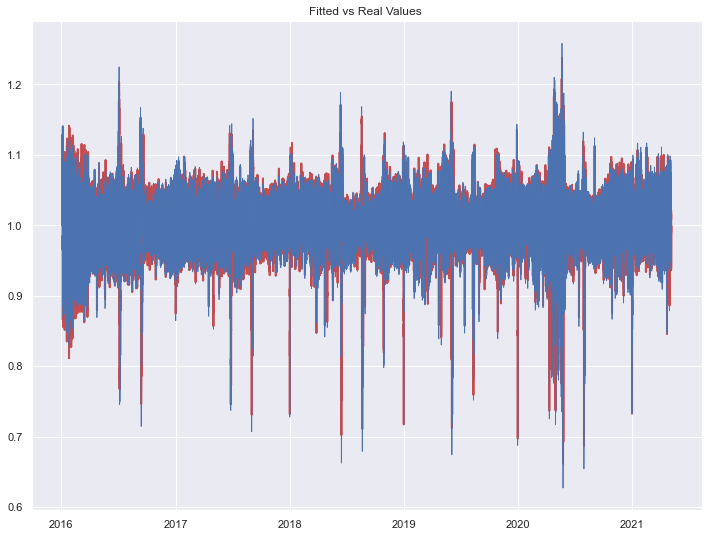

In [275]:
new_df = pd.DataFrame(model_fit.fittedvalues,  index = model_fit.fittedvalues.index)
new_df.columns = ["Fitted"]
new_df["Real"] = train_data
plt.plot(train_data.index,new_df.Fitted, c = "r",linewidth=2)
plt.plot(train_data.index,new_df.Real, c = "b", linewidth=0.8,)
plt.title("Fitted vs Real Values ")
plt.show()

## Forecasting 14 day ahead

In [267]:
forecast = model_fit.forecast(steps = 24*14)

C:\Users\bugra\Anaconda3_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


## Adding Trend and Seasonal Components to the train data

In [252]:
trend = trend.fillna(31652.898720)  #this value is the last trend value so I filled NA values with the last trend value 
trend_comp = trend.tail(14*24).values
season_comp = seasonality.tail(14*24).values

In [263]:
forecast_normalized = forecast.values*trend_comp*season_comp


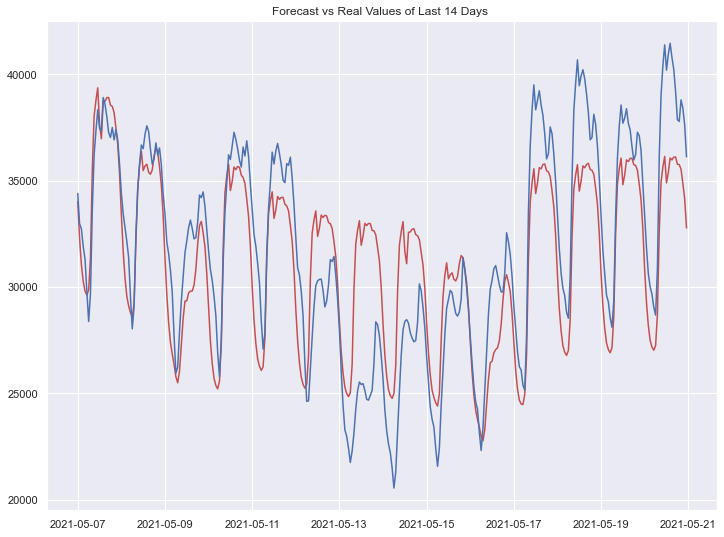

In [274]:
plt.plot(test_data.index,forecast_normalized, c = "r")
plt.plot(test_data.index,test_data, c = "b")
plt.title("Forecast vs Real Values of Last 14 Days ")
plt.show()

## Errors 

In [283]:
err_df

,Daily Error
2021-05-07 00:00:00,380.794213
2021-05-07 01:00:00,686.548377
2021-05-07 02:00:00,1686.087505
2021-05-07 03:00:00,1639.292784
2021-05-07 04:00:00,1502.456807
...,...
2021-05-20 19:00:00,2028.509679
2021-05-20 20:00:00,3265.864736
2021-05-20 21:00:00,3538.697933
2021-05-20 22:00:00,3470.793205


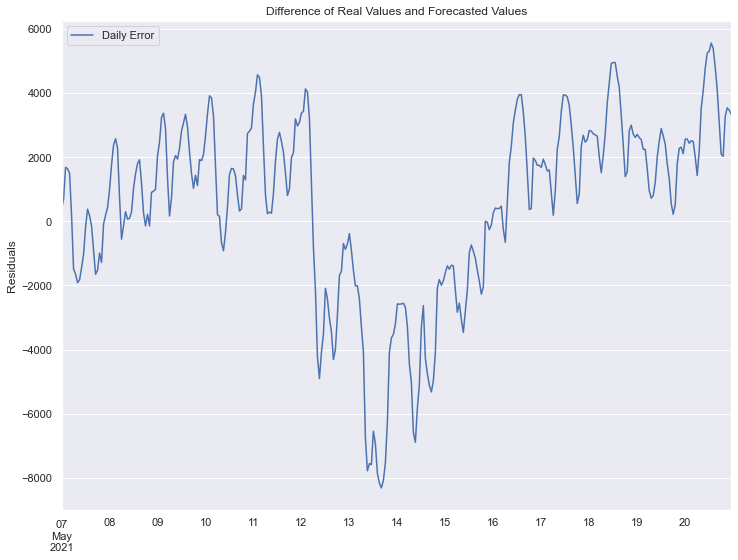

In [288]:
errors = test_data - forecast_normalized
err_df = pd.DataFrame(errors, index = test_data.index)
err_df.columns = ["Daily Error"]
err_df.plot()
plt.ylabel("Residuals")
plt.title("Difference of Real Values and Forecasted Values")
plt.legend()
plt.show();

## Daily Mean Absolute Percentage Error

In [294]:
dmape = err_df["Daily Error"]/ test_data
dmape = pd.DataFrame(dmape)
dmape.columns = ["Daily Mean Absolute Percentage Error"]
dmape

,Daily Mean Absolute Percentage Error
2021-05-07 00:00:00,0.011067
2021-05-07 01:00:00,0.020814
2021-05-07 02:00:00,0.051504
2021-05-07 03:00:00,0.051367
2021-05-07 04:00:00,0.047973
...,...
2021-05-20 19:00:00,0.053673
2021-05-20 20:00:00,0.084159
2021-05-20 21:00:00,0.092121
2021-05-20 22:00:00,0.092233


## Weighted Mean Absolute Percentage Err of the Model 

In [287]:
se_mape = abs(test_data-forecast_normalized)/test_data
ft_actual_sum = test_data.sum()
se_actual_prod_mape = test_data * se_mape
ft_actual_prod_mape_sum = se_actual_prod_mape.sum()
ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
ft_wmape_forecast

0.07506190594058443

# Conclusion 

### To summarize, in this homework, after manipulating the data and making it stationary, we prepared different AR and MA models by investigating the AIC values as p and q changes. After comparison of these models, we came up with a single model which have the lowest AIC score. Then we predicted the last 14 days of the data and calculated the errors with the realized data